In [1]:
using Plots
using Random
using LinearAlgebra
using StaticArrays

Lo primero, es pensar cómo representar las partículas y los nodos del arbol del algoritmo de Barnes Hut. Lo ideal sería crear un tipo de datos que represente a cada uno y guarde la información relevante. JUlia no soporta las clases, por lo tanto, vamos a crear estructuras de datos para representar partículas y nodos.

In [2]:
mutable struct Particle
    #Position
    pos::Array{Float64,1}
    
    #Velocity
    vel::Array{Float64,1}
    
    #Mass
    mass::Float64
end

struct Node
    #Side length of the cubical region of space represented by a node.
    size::Float64
    
    #Total mass of the node.
    total_mass::Float64
    
    #Center of mass of the node.
    center_of_mass::Array{Float64,1}
    
    #Children of a node in the octree.
    children::Array{Union{Node, Nothing},1}
end

Ahora, vamos a crear el esquema de integración temporal para el movimiento de cada partícula. Se utiliza PEFRL, que es un integrador simplectico de orden 4 en la posición. También existe una variación de este algoritmo que se llama VEFRL que es de orden 4 en la velocidad. 

In [3]:
function step_PEFRL(particles::Array{Particle,1}, tree::Node, Δt::Float64, θ::Float64, acc_func)
    const1 = 0.1786178958448091      #ζ
    const3 = -0.6626458266981849e-1  #χ
    const4 = -0.2123418310626054     #λ
    const2 = (1-2*const4)/2          #(1-2λ)/2
    const5 = 1-2*(const3+const1)     #1-2*(ζ+χ)
    for particle in particles
        particle.pos += particle.vel*Δt*const1
    end
    for particle in particles
        particle.vel += net_acc(particle, tree, θ, acc_func)*Δt*const2
        particle.pos += particle.vel*Δt*const3
    end
    for particle in particles
        particle.vel += net_acc(particle, tree, θ, acc_func)*Δt*const4
        particle.pos += particle.vel*Δt*const5
    end
    for particle in particles
        particle.vel += net_acc(particle, tree, θ, acc_func)*Δt*const4
        particle.pos += particle.vel*Δt*const3
    end
    for particle in particles
        particle.vel += net_acc(particle, tree, θ, acc_func)*Δt*const2
        particle.pos += particle.vel*Δt*const1
    end
end
function simulate(particles::Array{Particle,1}, steps::Int64; Δt::Float64 = 0.1, θ::Float64 = 0.5, acc_func = grav_acc, Nframes=200)    
    # Array to store simulation data
    frames = Array{Particle,1}[]
    draw=round(Int32,steps/Nframes)
    
    # Store initial conditions
    push!(frames, deepcopy(particles))
        
    for i = 1:steps
        #Perform time step integration
        step_PEFRL(particles, generate_tree(particles), Δt, θ, acc_func)
        
        #Save simulation data every draw steps 
        if i%draw==0
            push!(frames, deepcopy(particles))
        end
    end
        
    return frames
end

simulate! (generic function with 5 methods)

Lo que sigue es hacer una función que calcule la aceleración sobre cada partícula teniendo en cuenta el árbol. Esta función se moverá de forma recursiva por el árbol y calculará las fuerzas que actúan sobre cada partícula.

In [4]:
function net_acc(particle::Particle, node::Union{Node, Nothing}, θ::Float64, acc_func)
    if node == nothing
        # If tree is empty, return 0 acceleration
        zeros(Float64, 3)
    else
        # Barnes Hut method
        s = node.size                            # Width of the cube
        r = node.center_of_mass .- particle.pos  # Vector from particle to node center of mass.
        if s/sqrt(sum(r.^2)) < θ
            # If node size divided by distance is less than threshold θ, calculate gravitational acceleration.
            acc_func(node.total_mass, r)
        else
            # Recursive case
            sum(net_acc(particle, child, θ, acc_func) for child in node.children)
        end
    end
end

net_acc (generic function with 1 method)

Ahora solo queda pensar en el árbol de nodos. De una vez vamos a pensar en el código en 3 dimensiones, Nuevamente, la forma más sencilla se recorrer el árbol revisando si hay que actualizarlo o no es de forma recursiva. También se coloca una función auxiliar que contiene la lógica para clasificar las partículas en su respectivo octante.

In [5]:
function generate_tree(particles::Array{Particle,1}; return_boxes::Bool = false)
    # Calculate bounds of a box enclosing all particles
    minx, maxx = minimum(p -> p.pos[1], particles), maximum(p -> p.pos[1], particles)
    miny, maxy = minimum(p -> p.pos[2], particles), maximum(p -> p.pos[2], particles)
    minz, maxz = minimum(p -> p.pos[3], particles), maximum(p -> p.pos[3], particles)
    
    # Calculate corner and size of a cube enclosing all particles
    size = max(maxx - minx, maxy - miny, maxz - minz)
    corner = [minx, miny, minz]
    
    if return_boxes
        # Recursively compute tree of particles and return coordinates of boxes
        boxes = Tuple{Float64,Array{Float64,1}}[]
        boxes_aux = [Tuple{Float64,Array{Float64,1}}[]]
        generate_tree_aux(particles, size, corner, return_boxes, boxes_aux)
        append!(boxes, boxes_aux[1])
        return boxes
    else
        # Recursively compute tree of particles and return that tree
        return generate_tree_aux(particles, size, corner, false, Array{Tuple{Float64,Array{Float64,1}},1}[])
    end
end

function generate_tree_aux(particles::Array{Particle,1}, size::Float64, corner::Array{Float64,1},save_boxes::Bool, boxes_aux::Array{Array{Tuple{Float64,Array{Float64,1}},1},1})
    if save_boxes
        push!(boxes_aux[1], (size, corner))
    end
    
    if length(particles) == 0
        # If no particles in octant, return empty
        return Node(size/2, 0, corner .+ size/2, [nothing for i = 1:8])
    elseif length(particles) == 1
        # If one particle in octant, return node with that particle
        return Node(size/2, particles[1].mass, particles[1].pos, [nothing for i = 1:8])
    else
        # Recursive case
        # Calculate total mass and center of mass
        total_mass = sum(particle.mass for particle in particles)
        center_of_mass = sum(particle.mass .* particle.pos for particle in particles) / total_mass
        
        # Sort particles in 8 octants
        octants = [Particle[] for oct = 1:8]
        octants_aux = [[Particle[] for oct = 1:8]]
        new_corners = vec([corner + [i, j, k] for i = (0, size/2), j = (0, size/2), k = (0, size/2)])
        for particle in particles
            oct_num = 0
            for oct = 1:8
                if all(new_corners[oct] .<= particle.pos .<= new_corners[oct] .+ size/2)
                    oct_num = oct
                end
            end
            if oct_num != 0
                push!(octants_aux[1][oct_num], particle)
            end
        end
        for id = eachindex(octants_aux)
            for oct = 1:8
               append!(octants[oct], octants_aux[id][oct])
            end
        end
        
        # Calculate child nodes recursively
        children::Array{Union{Node, Nothing},1} = fill(nothing, 8)
        for oct = 1:8
            children[oct] = generate_tree_aux(octants[oct], size/2, new_corners[oct],save_boxes, boxes_aux)
        end
        
        return Node(size, total_mass, center_of_mass, children)
    end
end

generate_tree_aux (generic function with 1 method)

Ahora, quisieramos poder graficar las partículas, los octantes y además hacer una animación de la simulación, por lo tanto

In [6]:
function show_particles(particles::Array{Particle,1}, θ::Float64 = 30.0, ϕ::Float64 = 30.0)
    scatter([Tuple(p.pos) for p = particles],
        lims = (-1, 1),
        camera = (θ, ϕ),
        size = (500, 500),
        label = "",
        background_color = :black,
        marker = (:circle, 3, 0.8, :white, stroke(0)))
end

function show_boxes(particles::Array{Particle,1})
    p = scatter([Tuple(p.pos) for p = particles],
        camera = (30.0, 30.0),
        size = (500, 500),
        label = "",
        background_color = :black,
        marker = (:circle, 3, 0.8, :white, stroke(0)))
    boxes = generate_tree(particles, return_boxes = true)
    for (s, (x, y, z)) in boxes
        plot!([(x,y,z),(x+s,y,z),(x+s,y+s,z),(x,y+s,z),(x,y,z),(x,y,z+s),
               (x+s,y,z+s),(x+s,y+s,z+s),(x,y+s,z+s),(x,y,z+s),(x+s,y,z+s),
               (x+s,y,z),(x+s,y+s,z),(x+s,y+s,z+s),(x,y+s,z+s),(x,y+s,z)],
            linecolor = :red,
            label = "")
    end
    return p
end

function animate_frames(frames::Array{Array{Particle,1},1}, frame_rate::Int64 = 1, file_name = "animation"; θ::Float64 = 30.0, ϕ::Float64 = 30.0, quadview::Bool = false)
    anim = Animation()
    for i = 1:frame_rate:length(frames)
        if quadview
            show_quadview(frames[i])
        else
            show_particles(frames[i], θ, ϕ)
        end
        frame(anim)
    end
    gif(anim, "$file_name.gif")
end
function show_quadview(particles::Array{Particle,1})
    scatter([Tuple(p.pos) for p = particles],
        lims = (-1, 1),
        camera = (30, 30),
        size = (800, 800),
        label = "",
        background_color = :black,
        marker = (:circle, 3, 0.8, :white, stroke(0)),
        layout = 4,
        subplot = 1)
    scatter!([Tuple(p.pos) for p = particles],
        lims = (-1, 1),
        camera = (0, 90),
        label = "",
        marker = (:circle, 3, 0.8, :white, stroke(0)),
        subplot = 2)
    scatter!([Tuple(p.pos) for p = particles],
        lims = (-1, 1),
        camera = (90, 0),
        label = "",
        marker = (:circle, 3, 0.8, :white, stroke(0)),
        subplot = 3)
    scatter!([Tuple(p.pos) for p = particles],
        lims = (-1, 1),
        camera = (60, 30),
        label = "",
        marker = (:circle, 3, 0.8, :white, stroke(0)),
        subplot = 4)
end

show_quadview (generic function with 1 method)

Ya teneiendo todo lo necesario para la simulación, viene la parte física. La función que calcula la aceleración y la que inicializa el sistema. Es en estas dos funciones do nde se guarda la información de las unidades y la física del problema.

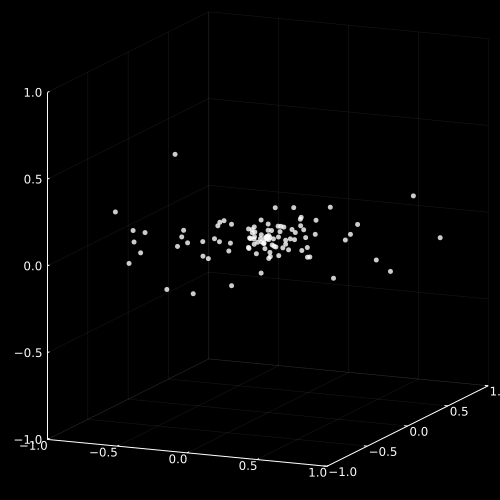

In [22]:
function rand_particles(num_particles::Int64)
    particles = Particle[]
    for i = 1:num_particles
        θ = 2π*rand()
        R = randexp()/ℯ
        z = (rand() > 0.5 ? 1 : -1) * (randexp()/(10ℯ))
        v = √(R*num_particles/1e6)
        mass = 1e4
        push!(particles, Particle([R*cos(θ), R*sin(θ), z], [v*sin(θ), -v*cos(θ), 0.0], mass))
    end
    particles
end

function grav_acc(mass::Float64, r::Array{Float64,1}; ϵ::Float64 = 0.02)
    # Calculate gravitational acceleration, using node center of mass
    # and softening factor ϵ (to prevent blow up at d2 = 0)
    G::Float64 = 6.67430e-11
    ((G * mass) / ((sum(r.^2)+ϵ^2)^(3/2))) .* r
end

particles = rand_particles(100)
show_particles(particles)

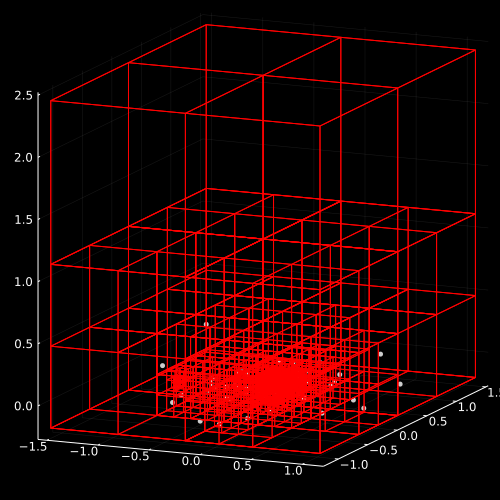

In [23]:
show_boxes(particles)

In [24]:
@time frames = simulate!(particles, 500)
print("done")

 23.233547 seconds (366.31 M allocations: 30.707 GiB, 19.81% gc time)
done

┌ Info: Saved animation to 
│   fn = /home/wind/Documents/Astrophysics/tareas/animation.gif
└ @ Plots /home/wind/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/wind/Documents/Astrophysics/tareas/animation.gif")
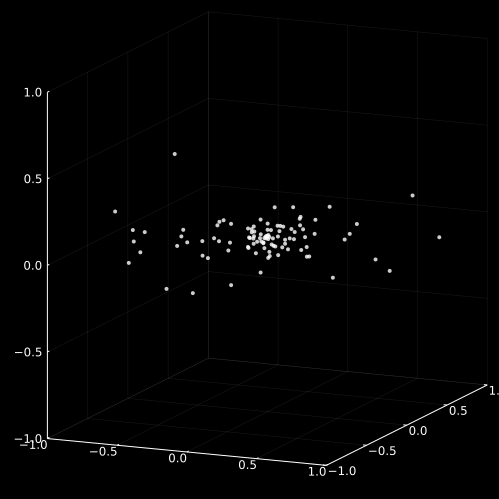

In [25]:
animate_frames(frames, 5, quadview = false)